# Vision por Computadora II - CEIA

### Trabajo Final

Autor: Karen Raczkowski

En el siguiente trabajo se busca clasificar imágenes de diferentes razas de perros utilizando redes neuronales.

Objetivo: identificar la raza de perros en imágenes.<br>
Problema: clasificación multiclase.<br>
Cantidad de clases: 120<br>
Nombre de las clases: nombres de 120 razas de perros, por ejemplo, 'Pekinese', 'Labrador', 'Bulldog', etc.<br>
Total de imágenes del dataset: 20,580<br>
División Train-Test: 80-20%<br>
Arquitecturas de modelos: ResNet18, ResNet50, VGG19<br>
Visualización GradCAM 

In [1]:
import random
import os
import platform
import sys
import numpy as np
import seaborn as sns
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

import torchvision
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as f

In [24]:
if 'google.colab' in sys.modules:
    !pip install torchmetrics
    !pip install --upgrade --no-cache-dir gdown
    import gdown

if 'google.colab' in sys.modules:
    from google.colab import drive
    drive.mount('/content/drive')

Descargar el dataset

In [12]:
# Correr solo si es necesario descargar el dataset
import requests

def download_file_from_onedrive(url, destination):
    response = requests.get(url, allow_redirects=True)
    if response.status_code == 200:
        with open(destination, 'wb') as file:
            file.write(response.content)
    else:
        print(f"Error al descargar el archivo: {response.status_code}")

# Enlace de descarga directa de OneDrive
onedrive_link = "https://onedrive.live.com/download.aspx?authkey=%21AERlgCBx8y6ZrOU&resid=75263E3DFDFB225E%2165439&cid=75263E3DFDFB225E&parId=root&parQt=sharedby&parCid=UnAuth&o=OneUp"

# Ruta de destino donde quieres guardar el archivo
destination_file = "Stanford_Dogs_Dataset.zip"

# Descargar el archivo
download_file_from_onedrive(onedrive_link, destination_file)

print(f"Archivo descargado en: {destination_file}")

Archivo descargado en: Stanford_Dogs_Dataset.zip


In [6]:
# Descomprimir
import zipfile

# Función para descomprimir el archivo
def unzip_file(zip_path, extract_to):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)

# Descomprimir el archivo
unzip_file("Stanford_Dogs_Dataset.zip", "./Stanford_Dogs_Dataset/")

print(f"Archivo descomprimido")

Archivo descomprimido


Visualización

Cantidad disponible de razas de perro: 120


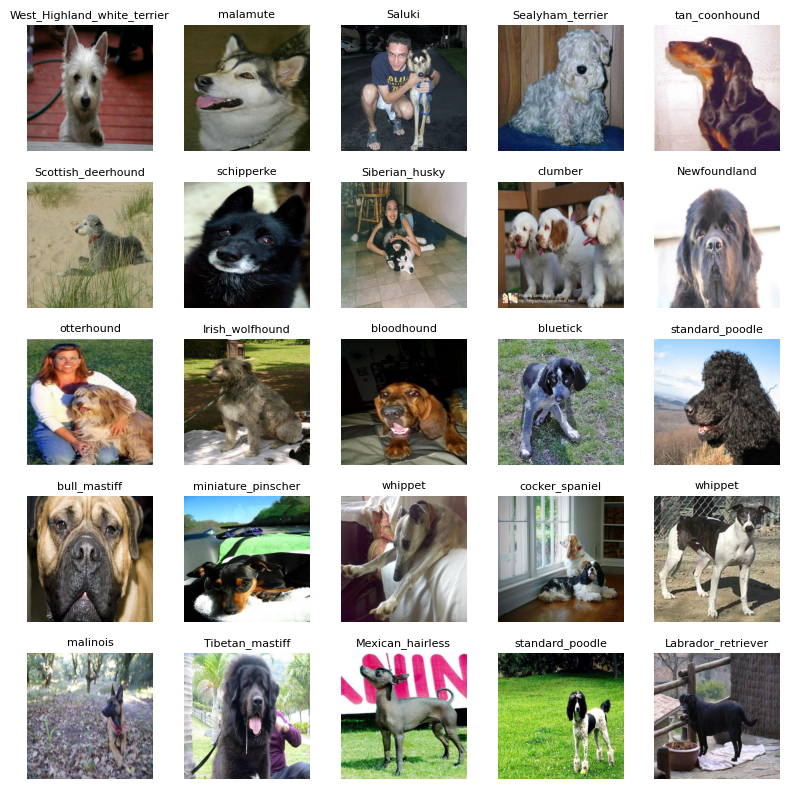

In [17]:
import random
from skimage.transform import resize
import matplotlib.pyplot as plt
import os
import numpy as np

# Define la ruta al directorio que contiene imágenes de perros
PATH = './Stanford_Dogs_Dataset/images/Images/'

# Mostrar el conteo de imágenes de perros en el directorio
print(f'Cantidad disponible de razas de perro: {len(os.listdir(PATH))}')

# Crear subplots para mostrar imágenes aleatorias
fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(8,8))

# Iterar a través de los subplots y mostrar imágenes aleatorias de perros
for indx, axis in enumerate(axes.flatten()):
    PATH_TEMP = random.choice(os.listdir(PATH))
    # Obtener un índice aleatorio dentro del rango de imágenes disponibles
    rnd_indx = np.random.randint(0, len(os.listdir(PATH+'/'+PATH_TEMP)))
    
    # Cargar y mostrar la imagen usando Matplotlib
    images = os.listdir(PATH+'/'+PATH_TEMP+'/')
    img = plt.imread(PATH+'/'+PATH_TEMP + '/'+images[rnd_indx])
    # Redimensiona la imagen a un tamaño constante (por ejemplo, 400x400)
    img = resize(img, (400,400))

    imgplot = axis.imshow(img)
    axis.set_axis_off()  # Desactiva el eje para una mejor visualización

    # Extraer el nombre de la raza del nombre de la carpeta
    raza_perro = PATH_TEMP.split('-')[-1]  # Extrae la parte después del guion
    axis.set_title(raza_perro, fontsize=8)

plt.tight_layout()
plt.show()

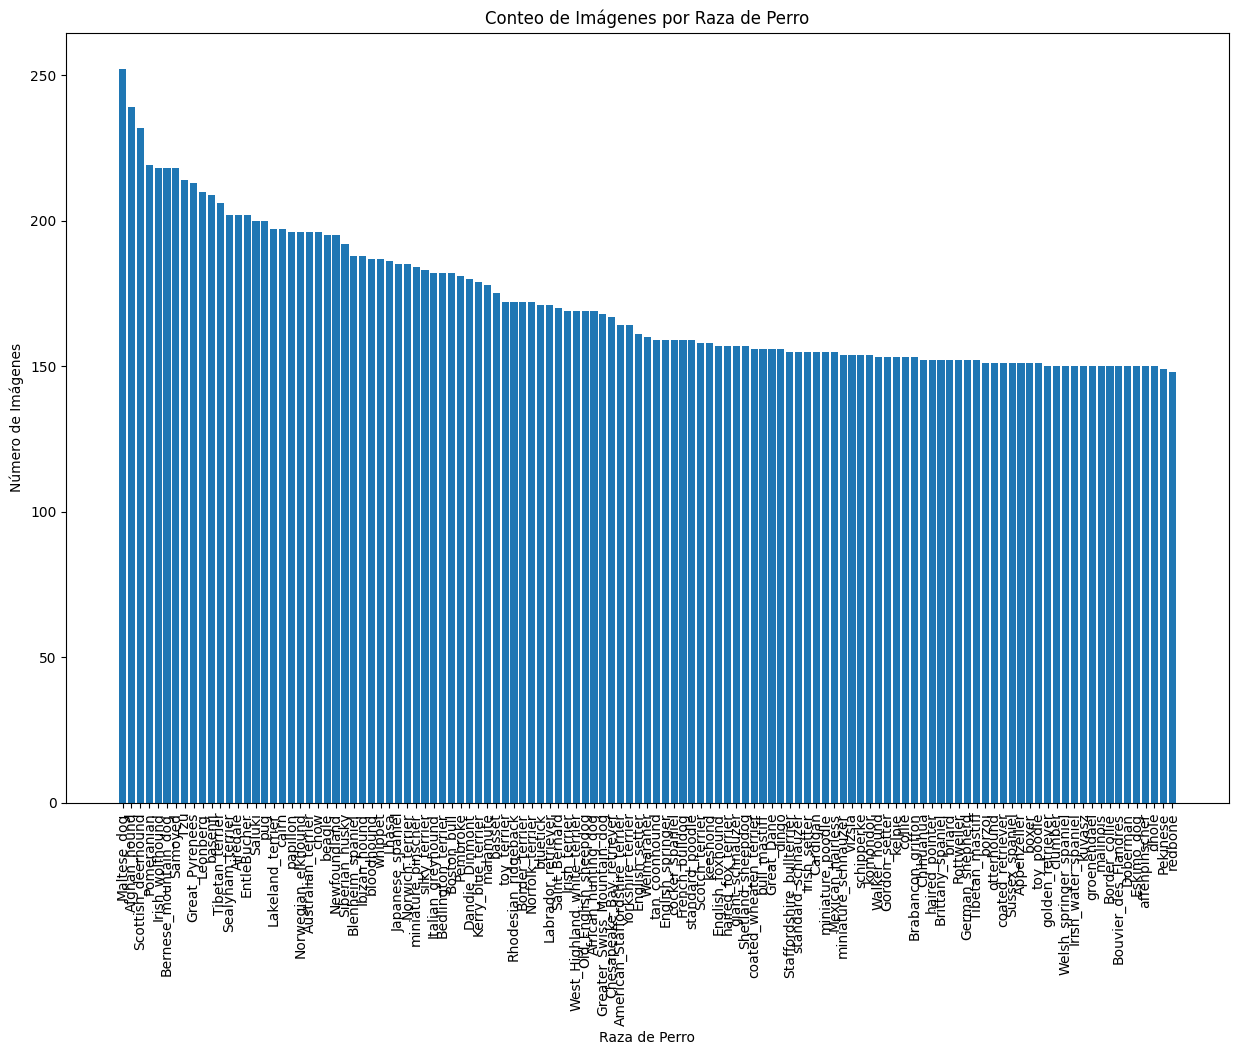

In [16]:
import os
import matplotlib.pyplot as plt

# Define la ruta al directorio que contiene imágenes de perros
path = './Stanford_Dogs_Dataset/images/Images/'

# Diccionario para almacenar el conteo de imágenes por raza
conteo_imagenes = {}

# Recorrer cada carpeta en el directorio
for raza in os.listdir(path):
    # Construir la ruta completa a la carpeta de la raza
    raza_path = os.path.join(path, raza)
    
    # Asegurarse de que es un directorio
    if os.path.isdir(raza_path):
        # Dividir el nombre de la carpeta para eliminar la parte numérica
        nombre_raza = raza.split('-')[-1]

        # Contar el número de archivos en el directorio
        conteo_imagenes[nombre_raza] = len([nombre for nombre in os.listdir(raza_path) if os.path.isfile(os.path.join(raza_path, nombre))])

# Ordenar el conteo de imágenes por raza de mayor a menor
conteo_ordenado = dict(sorted(conteo_imagenes.items(), key=lambda item: item[1], reverse=True))

# Crear un bar plot con el conteo
plt.figure(figsize=(15, 10))
plt.bar(conteo_ordenado.keys(), conteo_ordenado.values())
plt.xlabel('Raza de Perro')
plt.ylabel('Número de Imágenes')
plt.title('Conteo de Imágenes por Raza de Perro')
plt.xticks(rotation=90)
plt.show()

Image Preprocessing
We apply transformations to our images, resize them to 64x64 pixels, and apply random color jittering, rotation, and horizontal flipping. We convert these transformed images into tensors and normalize them. We load these images in batches of 32 from a folder and shuffle them for randomness. This approach enhances the diversity and size of our dataset, improving our model’s robustness.

In [ ]:
batch_size = 32
image_size = 64

random_transforms = [transforms.ColorJitter(), transforms.RandomRotation(degrees=20)]
transform = transforms.Compose([transforms.Resize(64),
                                transforms.CenterCrop(64),
                                transforms.RandomHorizontalFlip(p=0.5),
                                transforms.RandomApply(random_transforms, p=0.2),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_data = datasets.ImageFolder(PATH, transform=transform)
train_loader = torch.utils.data.DataLoader(train_data, shuffle=True,
                                           batch_size=batch_size)
                                           
imgs, label = next(iter(train_loader))
imgs = imgs.numpy().transpose(0, 2, 3, 1)

In [ ]:
fig, axs = plt.subplots(5,5, figsize = (8,8))

for i in range(5):
    for j in range(5):
        axs[i,j].imshow(imgs[5*i+j])
        axs[i,j].axis('off')

plt.show()

Weights
Defining the weights_init function

In [ ]:
def weights_init(m):
    """
    Takes as input a neural network m that will initialize all its weights.
    """
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

Generator

In [ ]:
class G(nn.Module):
    def __init__(self):
        # Used to inherit the torch.nn Module
        super(G, self).__init__()
        # Meta Module - consists of different layers of Modules
        self.main = nn.Sequential(
                nn.ConvTranspose2d(100, 512, 4, stride=1, padding=0, bias=False),
                nn.BatchNorm2d(512),
                nn.ReLU(True),
                nn.ConvTranspose2d(512, 256, 4, stride=2, padding=1, bias=False),
                nn.BatchNorm2d(256),
                nn.ReLU(True),
                nn.ConvTranspose2d(256, 128, 4, stride=2, padding=1, bias=False),
                nn.BatchNorm2d(128),
                nn.ReLU(True),
                nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1, bias=False),
                nn.BatchNorm2d(64),
                nn.ReLU(True),
                nn.ConvTranspose2d(64, 3, 4, stride=2, padding=1, bias=False),
                nn.Tanh()
                )
        
    def forward(self, input):
        output = self.main(input)
        return output

# Creating the generator
netG = G()
netG.apply(weights_init)

Discriminator

In [ ]:
# Defining the discriminator
class D(nn.Module):
    def __init__(self):
        super(D, self).__init__()
        self.main = nn.Sequential(
                nn.Conv2d(3, 64, 4, stride=2, padding=1, bias=False),
                nn.LeakyReLU(negative_slope=0.2, inplace=True),
                nn.Conv2d(64, 128, 4, stride=2, padding=1, bias=False),
                nn.BatchNorm2d(128),
                nn.LeakyReLU(negative_slope=0.2, inplace=True),
                nn.Conv2d(128, 256, 4, stride=2, padding=1, bias=False),
                nn.BatchNorm2d(256),
                nn.LeakyReLU(negative_slope=0.2, inplace=True),
                nn.Conv2d(256, 512, 4, stride=2, padding=1, bias=False),
                nn.BatchNorm2d(512),
                nn.LeakyReLU(negative_slope=0.2, inplace=True),
                nn.Conv2d(512, 1, 4, stride=1, padding=0, bias=False),
                nn.Sigmoid()
                )
        
    def forward(self, input):
        output = self.main(input)
        # .view(-1) = Flattens the output into 1D instead of 2D
        return output.view(-1)
    
    
# Creating the discriminator
netD = D()
netD.apply(weights_init)

Visualización

In [ ]:
if 'google.colab' in sys.modules:
  train_folder = '/content/DATASET/TRAIN'
  test_folder = '/content/DATASET/TEST'
  valid_folder = '/content/DATASET/VALID'
  dataset_folder = '/content/DATASET'
else:
  train_folder = 'DATASET/TRAIN'
  test_folder = 'DATASET/TEST'
  valid_folder = 'DATASET/VALID'
  dataset_folder = 'DATASET'

CLASES = []
for class_name in os.listdir(train_folder):
  CLASES.append(class_name)

CANTIDAD_CLASES = len(CLASES)
ANCHO_IMAGENES = 224
ALTO_IMAGENES = 224

print(f'CLASES: {CLASES}')
print(f'CANTIDAD_CLASES: {CANTIDAD_CLASES}')

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

fig, axs = plt.subplots(1, CANTIDAD_CLASES, figsize=(20, 20))

for id, class_folder in enumerate(sorted(os.listdir(train_folder))):

    image_name = random.choice(os.listdir(os.path.join(train_folder, class_folder)))
    image = mpimg.imread(os.path.join(train_folder, class_folder, image_name))

    axs[id].imshow(image)
    axs[id].set_title(class_folder)

print(f'Device: {device}')

Definición de la función de entrenamiento

In [ ]:
def train(model, optimizer, criterion, metric, data, epochs, tb_writer=None):
    from PIL import ImageFile
    ImageFile.LOAD_TRUNCATED_IMAGES = True

    train_loader = data["train"]
    valid_loader = data["valid"]

    train_writer = tb_writer["train"]
    valid_writer = tb_writer["valid"]

    if tb_writer:
        train_writer.add_graph(model, torch.zeros((1, 3, data["image_width"], data["image_height"])))
        valid_writer.add_graph(model, torch.zeros((1, 3, data["image_width"], data["image_height"])))

    if torch.cuda.is_available():
        model.to("cuda")
        metric.to("cuda")

    train_loss = []
    train_acc = []
    valid_loss = []
    valid_acc = []

    for epoch in range(epochs):

        # Pongo el modelo en modo entrenamiento
        model.train()

        epoch_train_loss = 0.0
        epoch_train_accuracy = 0.0

        for train_data, train_target in train_loader:

            if torch.cuda.is_available():
                train_data = train_data.to("cuda")
                train_target = train_target.to("cuda")

            optimizer.zero_grad()
            output = model(train_data.float())
            loss = criterion(output, train_target)
            epoch_train_loss += loss.item()
            loss.backward()
            optimizer.step()

            accuracy = metric(output, train_target)
            epoch_train_accuracy += accuracy.item()

        epoch_train_loss = epoch_train_loss / len(train_loader)
        epoch_train_accuracy = epoch_train_accuracy / len(train_loader)
        train_loss.append(epoch_train_loss)
        train_acc.append(epoch_train_accuracy)

        # Pongo el modelo en modo testeo
        model.eval()

        epoch_valid_loss = 0.0
        epoch_valid_accuracy = 0.0

        for valid_data, valid_target in valid_loader:
            if torch.cuda.is_available():
                valid_data = valid_data.to("cuda")
                valid_target = valid_target.to("cuda")

            output = model(valid_data.float())
            epoch_valid_loss += criterion(output, valid_target).item()
            epoch_valid_accuracy += metric(output, valid_target).item()

        epoch_valid_loss = epoch_valid_loss / len(valid_loader)
        epoch_valid_accuracy = epoch_valid_accuracy / len(valid_loader)
        valid_loss.append(epoch_valid_loss)
        valid_acc.append(epoch_valid_accuracy)

        print("Epoch: {}/{} - Train loss {:.6f} - Train Accuracy {:.6f} - Valid Loss {:.6f} - Valid Accuracy {:.6f}".format(
        epoch+1, epochs, epoch_train_loss, epoch_train_accuracy, epoch_valid_loss, epoch_valid_accuracy))

        if tb_writer:
            train_writer.add_scalar("loss", epoch_train_loss, epoch)
            valid_writer.add_scalar("loss", epoch_valid_loss, epoch)
            train_writer.add_scalar("accuracy", epoch_train_accuracy, epoch)
            valid_writer.add_scalar("accuracy", epoch_valid_accuracy, epoch)
            train_writer.flush()
            valid_writer.flush()

    history = {}
    history["train_loss"] = train_loss
    history["train_acc"] = train_acc
    history["valid_loss"] = valid_loss
    history["valid_acc"] = valid_acc

    return history

In [ ]:
aug_data_transforms = torchvision.transforms.Compose([
                        torchvision.transforms.Resize(size=(ANCHO_IMAGENES, ALTO_IMAGENES)),
                        torchvision.transforms.RandomHorizontalFlip(0.5),
                        torchvision.transforms.RandomResizedCrop(size=(ANCHO_IMAGENES,
                                                                       ALTO_IMAGENES),
                                                                 scale=(0.5, 1.0)),
                        #torchvision.transforms.ColorJitter(saturation=0.1, hue=0.1),
                        torchvision.transforms.ToTensor(),
                        torchvision.transforms.Normalize(mean=(0.485, 0.456, 0.406),
                                                         std=(0.229, 0.224, 0.225))
                      ])

data_transforms = torchvision.transforms.Compose([
                    torchvision.transforms.Resize(size=(ANCHO_IMAGENES, ALTO_IMAGENES)),
                    torchvision.transforms.ToTensor()
                  ])

train_set = torchvision.datasets.ImageFolder(root=train_folder
                                                    , transform=data_transforms)
test_set = torchvision.datasets.ImageFolder(root=test_folder
                                                    , transform=data_transforms)


train_loader = torch.utils.data.DataLoader(train_set, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=32, shuffle=True)

In [ ]:
idx_to_name = {}
for cls, i in enumerate(train_loader.dataset.classes):
  idx_to_name[cls] = i

idx_to_name

In [ ]:
def image_loader(loader, image_name):
    image = Image.open(image_name)
    image = loader(image).float().to(device)
    image.clone().detach().requires_grad_(True)
    image = image.unsqueeze(0)
    return image

data_transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize(size=(ANCHO_IMAGENES, ALTO_IMAGENES)),
    torchvision.transforms.ToTensor()
])